# Dependencies loading

In [45]:
import pandas as pd
import numpy as np
import seaborn as sns # Data Visualization
import matplotlib.pyplot as plt # Data Visualization
from matplotlib.ticker import FuncFormatter, LogLocator # Data Visualization
import plotly.express as px # Data Visualization
import statsmodels.api as sm # Statistics
import statsmodels.tsa.api as tsa # Statistics
from scipy.stats import norm, skew, kurtosis # Statistics
from scipy.optimize import minimize # Statistics
from pandas_datareader import data as pdr #import data from FRED
from datetime import datetime # Date and Time
from arch import arch_model # TS
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [46]:
import warnings
warnings.filterwarnings("ignore")

# Data preparation

## Data loading

In [47]:
BTC_url = 'https://raw.githubusercontent.com/IlyaSshnip/RR_project/main/Bitcoin_daily.csv'
SP500_url = 'https://raw.githubusercontent.com/IlyaSshnip/RR_project/main/S&P500.csv'
TMUBMUSD01Y_url = 'https://raw.githubusercontent.com/IlyaSshnip/RR_project/main/TMUBMUSD01Y.csv'


df_BTC = pd.read_csv(BTC_url, parse_dates=['Date'])
df_BTC.columns = df_BTC.columns.str.strip()

df_SP500 = pd.read_csv(SP500_url, parse_dates=['Date'])
df_SP500.columns = df_SP500.columns.str.strip()

df_TMUBMUSD01Y = pd.read_csv(TMUBMUSD01Y_url, parse_dates=['Date'])
df_TMUBMUSD01Y.columns = df_TMUBMUSD01Y.columns.str.strip()

start=datetime(2014, 5, 1)
end=datetime(2024, 5, 1)

# Macroeconomic Indicators (from FRED):

UN_Rate = pdr.get_data_fred('UNRATE', start, end) # Unemployment Rate
Real_GDP = pdr.get_data_fred('A191RL1Q225SBEA', start, end) # Real GDP
CPI = pdr.get_data_fred('CPIAUCSL', start, end) # Consumer Price Index
VIX = pdr.get_data_fred('VIXCLS', start, end) # Volatility Index
Ten_Year_Treasury_Yield = pdr.get_data_fred('DGS10', start, end) # 10-Year Treasury Yield
Federal_Funds_Rate = pdr.get_data_fred('FEDFUNDS', start, end) # Federal Funds Rate
BBB_Credit_Spread = pdr.get_data_fred('BAMLC0A4CBBB', start, end) # BBB Credit Spread

#print(df_BTC.head())
print(df_SP500.head())
#print(df_TMUBMUSD01Y.head())
# print(UN_Rate.head())
# print(Real_GDP.head())
# print(CPI.head())
# print(VIX.head())
# print(Ten_Year_Treasury_Yield.head())
# print(Federal_Funds_Rate.head())
# print(BBB_Credit_Spread.head())

        Date         Open         High          Low        Close    Adj Close  \
0 2014-05-01  1884.390015  1888.589966  1878.040039  1883.680054  1883.680054   
1 2014-05-02  1885.300049  1891.329956  1878.500000  1881.140015  1881.140015   
2 2014-05-05  1879.449951  1885.510010  1866.770020  1884.660034  1884.660034   
3 2014-05-06  1883.689941  1883.689941  1867.719971  1867.719971  1867.719971   
4 2014-05-07  1868.530029  1878.829956  1859.790039  1878.209961  1878.209961   

       Volume  
0  3416740000  
1  3159560000  
2  2733730000  
3  3327260000  
4  3632950000  


## Dataset adjustment

In [48]:
print(df_SP500.columns)
print(df_BTC.columns)
print(df_TMUBMUSD01Y.columns)
# Select Columns
df_SP500.rename(columns={'Close': 'SP500_Price'}, inplace=True)
print(df_SP500.head())
df_BTC.rename(columns={'Price': 'BTC_Price'}, inplace=True)
print(df_BTC.head())
df_TMUBMUSD01Y.rename(columns={'Close': 'TBONDS_Price'}, inplace=True)
print(df_TMUBMUSD01Y.head())

########################################################################################

# Define Price as 'numeric'

df_SP500['SP500_Price'] = df_SP500['SP500_Price'].astype(str)
df_BTC['BTC_Price'] = df_BTC['BTC_Price'].astype(str)
df_TMUBMUSD01Y['TBONDS_Price'] = df_TMUBMUSD01Y['TBONDS_Price'].astype(str)

df_SP500['SP500_Price'] = pd.to_numeric(df_SP500['SP500_Price'].str.replace(',', ''), errors='coerce')
df_BTC['BTC_Price'] = pd.to_numeric(df_BTC['BTC_Price'].str.replace(',', ''), errors='coerce')
df_TMUBMUSD01Y['TBONDS_Price'] = pd.to_numeric(df_TMUBMUSD01Y['TBONDS_Price'].str.replace(',', ''), errors='coerce')

########################################################################################
# Date
df_SP500['Date'] = pd.to_datetime(df_SP500['Date'])
df_SP500.set_index('Date', inplace=True)


df_BTC['Date'] = pd.to_datetime(df_BTC['Date'])
df_BTC.set_index('Date', inplace=True)


df_TMUBMUSD01Y['Date'] = pd.to_datetime(df_TMUBMUSD01Y['Date'])
df_TMUBMUSD01Y.set_index('Date', inplace=True)

# Sort by Date
df_SP500.sort_index(inplace=True)
df_BTC.sort_index(inplace=True)
df_TMUBMUSD01Y.sort_index(inplace=True)

df_SP500 = df_SP500.loc[start:end]
df_BTC = df_BTC.loc[start:end] # Cryptocurrency market is open on weekends
df_TMUBMUSD01Y = df_TMUBMUSD01Y.loc[start:end]

########################################################################################

# print(df_SP500.head())
# print(df_SP500.tail()) 
# print(df_TMUBMUSD01Y.head())
# print(df_TMUBMUSD01Y.tail())
# print(df_BTC.tail())

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')
Index(['Date', 'Open', 'High', 'Low', 'Close'], dtype='object')
        Date         Open         High          Low  SP500_Price    Adj Close  \
0 2014-05-01  1884.390015  1888.589966  1878.040039  1883.680054  1883.680054   
1 2014-05-02  1885.300049  1891.329956  1878.500000  1881.140015  1881.140015   
2 2014-05-05  1879.449951  1885.510010  1866.770020  1884.660034  1884.660034   
3 2014-05-06  1883.689941  1883.689941  1867.719971  1867.719971  1867.719971   
4 2014-05-07  1868.530029  1878.829956  1859.790039  1878.209961  1878.209961   

       Volume  
0  3416740000  
1  3159560000  
2  2733730000  
3  3327260000  
4  3632950000  
        Date BTC_Price      Open      High       Low     Vol. Change %
0 2024-05-01  58,331.2  60,665.0  60,827.5  56,643.5  171.55K   -3.85%
1 2024-04-30  60,666.6  63,852.4  64,700

## Returns calculation (Daily)

In [49]:
df_SP500['Return'] = df_SP500['SP500_Price'].pct_change() 
df_BTC['Return'] = df_BTC['BTC_Price'].pct_change() 
df_TMUBMUSD01Y['Return'] = df_TMUBMUSD01Y['TBONDS_Price'].pct_change() 

## Cumulative Returns calculation

In [50]:
 print(df_SP500.head())
 print(df_TMUBMUSD01Y.head())
 print(df_BTC.head())

                   Open         High          Low  SP500_Price    Adj Close  \
Date                                                                          
2014-05-01  1884.390015  1888.589966  1878.040039  1883.680054  1883.680054   
2014-05-02  1885.300049  1891.329956  1878.500000  1881.140015  1881.140015   
2014-05-05  1879.449951  1885.510010  1866.770020  1884.660034  1884.660034   
2014-05-06  1883.689941  1883.689941  1867.719971  1867.719971  1867.719971   
2014-05-07  1868.530029  1878.829956  1859.790039  1878.209961  1878.209961   

                Volume    Return  
Date                              
2014-05-01  3416740000       NaN  
2014-05-02  3159560000 -0.001348  
2014-05-05  2733730000  0.001871  
2014-05-06  3327260000 -0.008988  
2014-05-07  3632950000  0.005616  
             Open   High    Low  TBONDS_Price    Return
Date                                                   
2014-05-01  0.109  0.117  0.096         0.104       NaN
2014-05-02  0.102  0.114  0.096  

# Exploratory Data Analysis

## Summary Statistics

In [51]:
print(df_SP500.describe())
print(df_BTC.describe())
print(df_TMUBMUSD01Y.describe())

              Open         High          Low  SP500_Price    Adj Close  \
count  2517.000000  2517.000000  2517.000000  2517.000000  2517.000000   
mean   3109.840062  3126.493792  3091.923139  3110.347695  3110.347695   
std     944.320508   950.120495   938.476318   944.565837   944.565837   
min    1833.400024  1847.000000  1810.099976  1829.079956  1829.079956   
25%    2178.610107  2184.939941  2172.199951  2180.389893  2180.389893   
50%    2858.649902  2873.229980  2847.649902  2859.530029  2859.530029   
75%    3998.429932  4023.919922  3965.209961  3992.929932  3992.929932   
max    5257.970215  5264.850098  5245.819824  5254.350098  5254.350098   

             Volume       Return  
count  2.517000e+03  2516.000000  
mean   3.965731e+09     0.000454  
std    9.657907e+08     0.011169  
min    1.296530e+09    -0.119841  
25%    3.374700e+09    -0.003781  
50%    3.789370e+09     0.000596  
75%    4.319660e+09     0.005679  
max    9.976520e+09     0.093828  
          BTC_Pric

## Check for Missing Values

In [52]:
print(df_SP500.isnull().sum())
print(df_BTC.isnull().sum())
print(df_TMUBMUSD01Y.isnull().sum())

Open           0
High           0
Low            0
SP500_Price    0
Adj Close      0
Volume         0
Return         1
dtype: int64
BTC_Price    0
Open         0
High         0
Low          0
Vol.         0
Change %     0
Return       1
dtype: int64
Open            0
High            0
Low             0
TBONDS_Price    0
Return          1
dtype: int64


## Price Changes of the S&P 500 Index, Bitcoin, and the 1-Year U.S. Treasury Bond

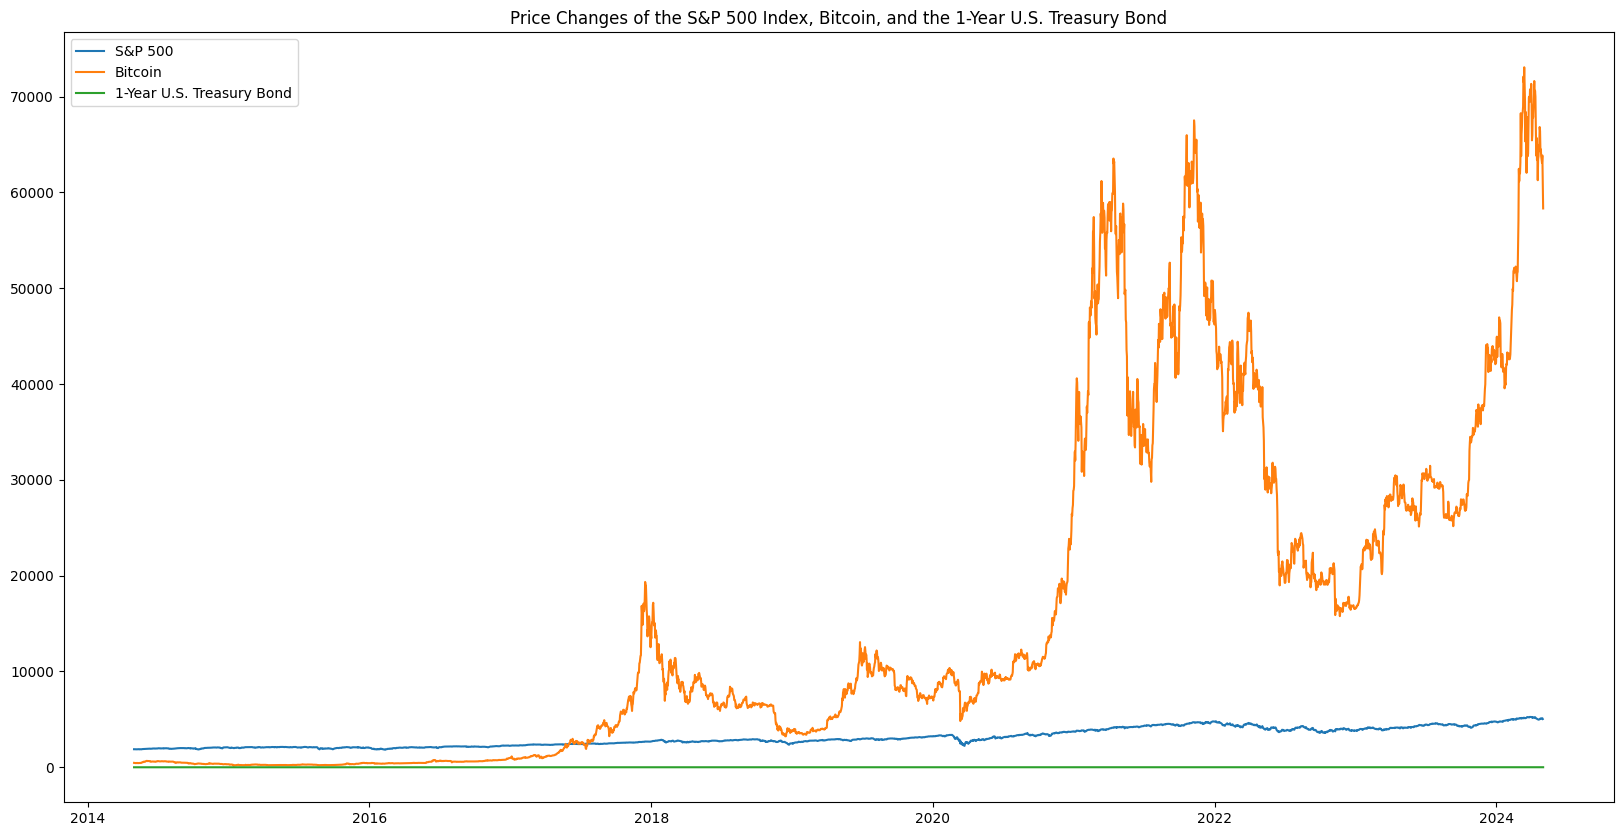

In [53]:
plt.figure(figsize=(20, 10))

plt.plot(df_SP500.index, df_SP500['SP500_Price'], label='S&P 500')
plt.plot(df_BTC.index, df_BTC['BTC_Price'], label='Bitcoin')
plt.plot(df_TMUBMUSD01Y.index, df_TMUBMUSD01Y['TBONDS_Price'], label='1-Year U.S. Treasury Bond')

plt.xlabel('')
plt.ylabel('')
plt.title('Price Changes of the S&P 500 Index, Bitcoin, and the 1-Year U.S. Treasury Bond')
plt.legend()
plt.show()

### S&P 500 Index

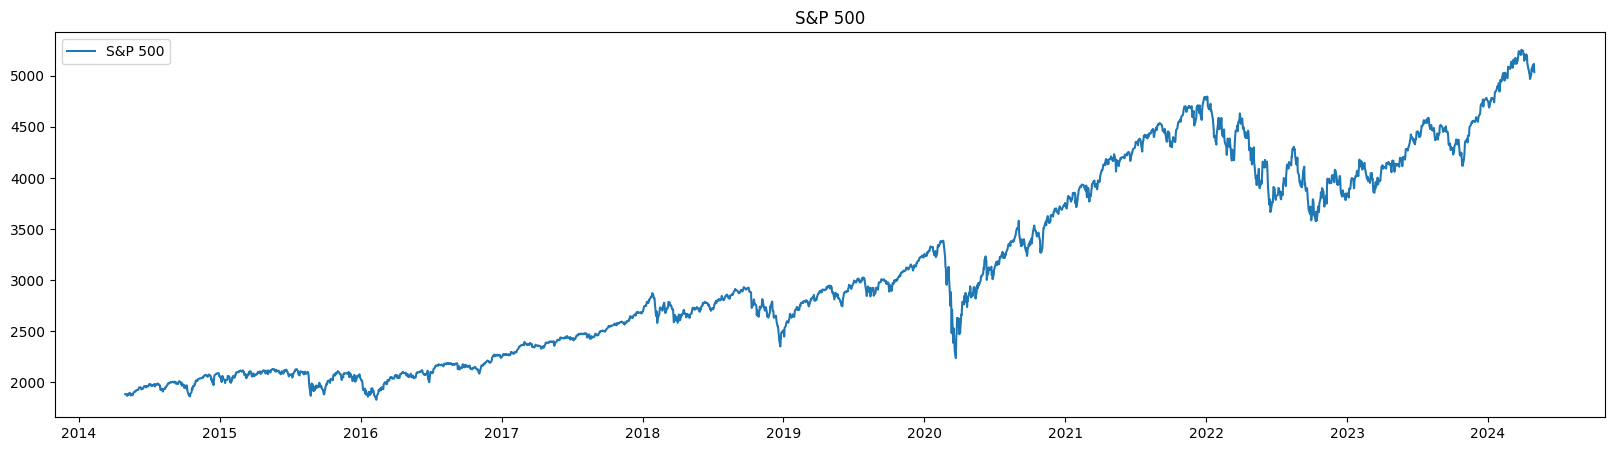

In [54]:
plt.figure(figsize=(20, 5))
plt.plot(df_SP500.index, df_SP500['SP500_Price'], label='S&P 500')
plt.xlabel('')
plt.ylabel('')
plt.title('S&P 500')
plt.legend()
plt.grid(False)
plt.show()

### Bitcoin

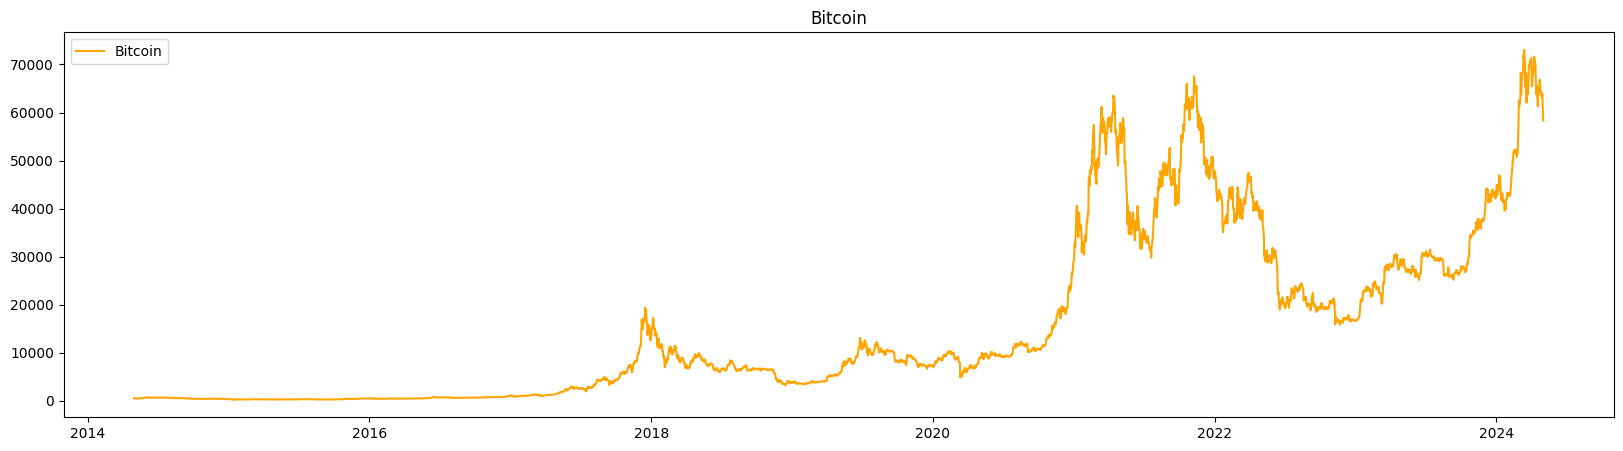

In [55]:
plt.figure(figsize=(20, 5))
plt.plot(df_BTC.index, df_BTC['BTC_Price'], label='Bitcoin', color='orange')
plt.xlabel('')
plt.ylabel('')
plt.title('Bitcoin')
plt.legend()
plt.grid(False)
plt.show()

### 1-Year U.S. Treasury Bond

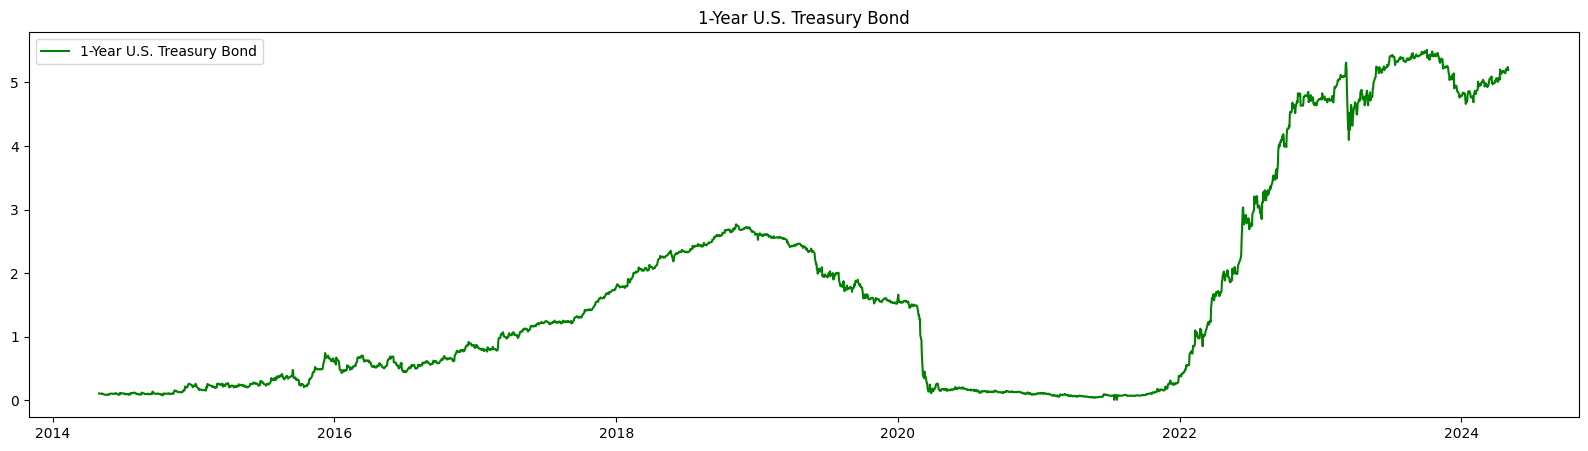

In [56]:
plt.figure(figsize=(20, 5))
plt.plot(df_TMUBMUSD01Y.index, df_TMUBMUSD01Y['TBONDS_Price'], label='1-Year U.S. Treasury Bond', color='green')
plt.xlabel('')
plt.ylabel('')
plt.title('1-Year U.S. Treasury Bond')
plt.legend()
plt.grid(False)
plt.show()

## Daily Returns

In [57]:
df_combined_returns = pd.concat([df_SP500[['Return']], df_BTC[['Return']], df_TMUBMUSD01Y[['Return']]], axis=1, join='inner')
df_combined_returns.columns = ['SP500_Return', 'BTC_Return', 'TMUBMUSD01Y_Return']

In [58]:
df_combined_returns

,SP500_Return,BTC_Return,TMUBMUSD01Y_Return
Date,,,
2014-05-01,NaN,NaN,NaN
2014-05-02,-0.001348,-0.013910,0.000000
2014-05-05,0.001871,-0.011697,-0.019231
2014-05-06,-0.008988,0.003017,0.000000
2014-05-07,0.005616,0.033087,-0.029412
...,...,...,...
2024-04-24,0.000213,-0.032061,0.001944
2024-04-25,-0.004576,0.003288,0.010475
2024-04-26,0.010209,-0.011329,-0.002496


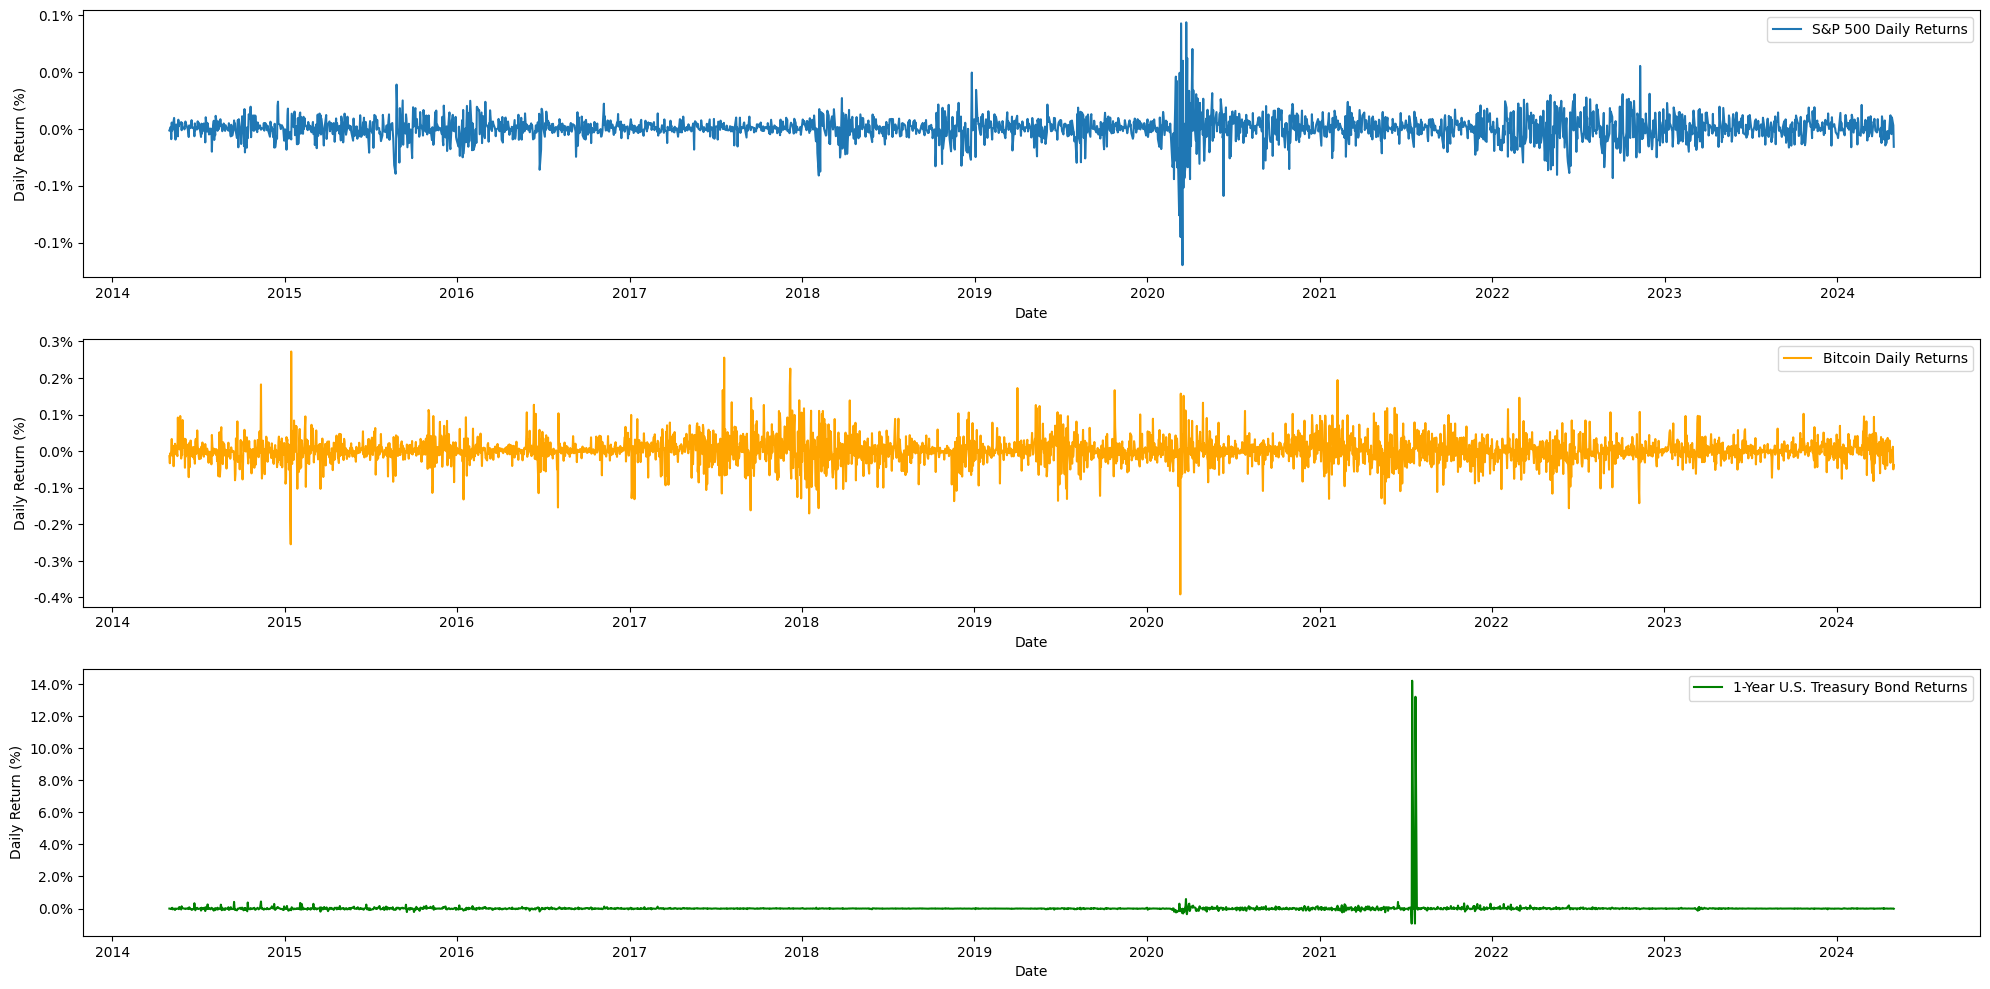

In [59]:
def percentage_formatter(x, pos):
    return f'{x:.1f}%'

plt.figure(figsize=(20, 10))

plt.subplot(3, 1, 1)
plt.plot(df_SP500.index, df_SP500['Return'], label='S&P 500 Daily Returns')
plt.title('')
plt.xlabel('Date')
plt.ylabel('Daily Return (%)')
plt.gca().yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(df_BTC.index, df_BTC['Return'], label='Bitcoin Daily Returns', color='orange')
plt.title('')
plt.xlabel('Date')
plt.ylabel('Daily Return (%)')
plt.gca().yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(df_TMUBMUSD01Y.index, df_TMUBMUSD01Y['Return'], label='1-Year U.S. Treasury Bond Returns', color='green')
plt.title('')
plt.xlabel('Date')
plt.ylabel('Daily Return (%)')
plt.gca().yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
plt.legend()

plt.tight_layout()
plt.show()

### Correlation

In [60]:
""" Forward-filling missing values ensures consistency gaps 
by filling gaps with the last available observation, which is essential 
when aligning datasets with different trading schedules
, such as traditional markets and Bitcoin (Open on Weekends)."""

# This piece of code was taken from ChapGPT 
# Recommended using Forward-filling for Bitcoin

df_SP500 = df_SP500.asfreq('D').fillna(method='ffill')
df_TMUBMUSD01Y = df_TMUBMUSD01Y.asfreq('D').fillna(method='ffill')

# Merge files & Rename Columns
df_assets = pd.merge(df_SP500, df_BTC, on='Date', how='outer')
df_assets = pd.merge(df_assets, df_TMUBMUSD01Y, on='Date', how='outer')
print(df_assets.columns)
df_assets = df_assets.drop(columns=['Open_x', 'High_x', 'Low_x', 'Adj Close', 'Volume',
        'Open_y', 'High_y', 'Low_y', 'Vol.',
       'Change %', 'Open', 'High', 'Low'])
df_assets.columns = ['SP500_Price', 'SP500_Return', 'BTC_Price', 'BTC_Return', 'TMUBMUSD01Y_Price', 'TMUBMUSD01Y_Return']

# Drop NaN
df_assets.dropna(subset=['SP500_Return', 'BTC_Return', 'TMUBMUSD01Y_Return'], inplace=True)
print(df_assets)
# print(df_assets.head())

Index(['Open_x', 'High_x', 'Low_x', 'SP500_Price', 'Adj Close', 'Volume',
       'Return_x', 'BTC_Price', 'Open_y', 'High_y', 'Low_y', 'Vol.',
       'Change %', 'Return_y', 'Open', 'High', 'Low', 'TBONDS_Price',
       'Return'],
      dtype='object')
            SP500_Price  SP500_Return  BTC_Price  BTC_Return  \
Date                                                           
2014-05-02  1881.140015     -0.001348      453.7   -0.013910   
2014-05-03  1881.140015     -0.001348      438.6   -0.033282   
2014-05-04  1881.140015     -0.001348      436.0   -0.005928   
2014-05-05  1884.660034      0.001871      430.9   -0.011697   
2014-05-06  1867.719971     -0.008988      432.2    0.003017   
...                 ...           ...        ...         ...   
2024-04-26  5099.959961      0.010209    63766.4   -0.011329   
2024-04-27  5099.959961      0.010209    63456.8   -0.004855   
2024-04-28  5099.959961      0.010209    63109.7   -0.005470   
2024-04-29  5116.169922      0.003178    63

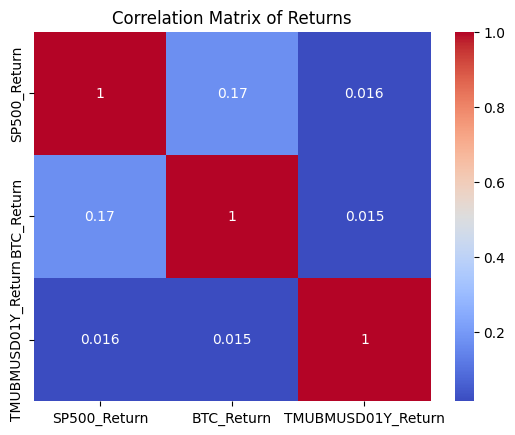

In [61]:
correlation_matrix = df_assets[['SP500_Return', 'BTC_Return', 'TMUBMUSD01Y_Return']].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Returns')
plt.show()

The correlation matrix shows that S&P 500 and Bitcoin returns have a weak positive correlation (0.17), while both have minimal correlation with 1-Year U.S. Treasury returns.

## Statistical Analysis

### Summary

In [62]:
print(df_combined_returns.describe())

       SP500_Return   BTC_Return  TMUBMUSD01Y_Return
count   2500.000000  2500.000000         2500.000000
mean       0.000462     0.002399            0.013386
std        0.011183     0.039886            0.392496
min       -0.119841    -0.391816           -0.934211
25%       -0.003789    -0.013977           -0.011549
50%        0.000600     0.001383            0.000000
75%        0.005692     0.019091            0.013143
max        0.093828     0.272286           14.200000


In [63]:
print(df_combined_returns.skew())

SP500_Return          -0.518575
BTC_Return            -0.129652
TMUBMUSD01Y_Return    34.090014
dtype: float64


In [64]:
print(df_combined_returns.kurtosis())

SP500_Return            14.934157
BTC_Return               8.516432
TMUBMUSD01Y_Return    1192.704632
dtype: float64


### ADF

In [65]:
def adf_test(series):
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print("Reject the null hypothesis - stationary")
    else:
        print("Fail to reject the null hypothesis - non-stationary")

adf_test(df_combined_returns['SP500_Return'])
adf_test(df_combined_returns['BTC_Return'])
adf_test(df_combined_returns['TMUBMUSD01Y_Return'])

ADF Statistic: -15.696102760271707
p-value: 1.4145081703855867e-28
Reject the null hypothesis - stationary
ADF Statistic: -27.879839702337545
p-value: 0.0
Reject the null hypothesis - stationary
ADF Statistic: -8.657891314817109
p-value: 4.9121247555259015e-14
Reject the null hypothesis - stationary


We reject the null hypothesis, concluding that the data is stationary.

### KDE

The KDE plots show that the distributions of S&P 500 and Bitcoin returns are centered around zero with heavy tails, suggesting high volatility. In contrast, the 1-Year U.S. Treasury Bond returns display positive skew with extreme values.

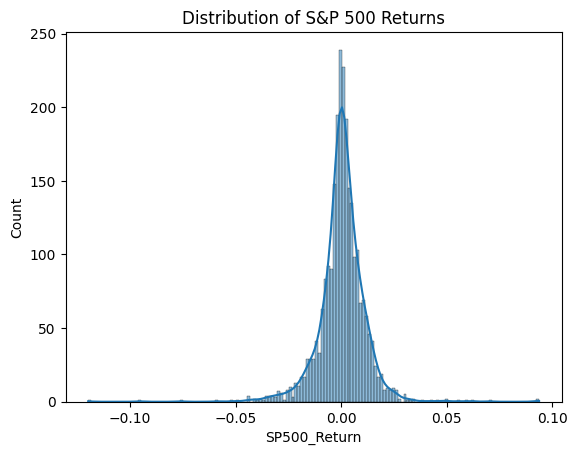

In [66]:
sns.histplot(df_combined_returns['SP500_Return'], kde=True)
plt.title('Distribution of S&P 500 Returns')
plt.show()

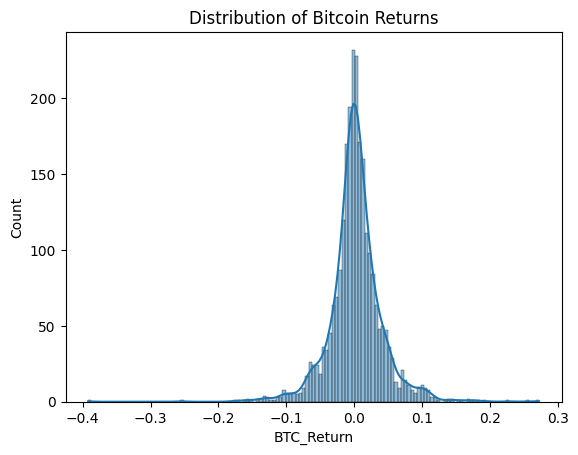

In [67]:
sns.histplot(df_combined_returns['BTC_Return'], kde=True)
plt.title('Distribution of Bitcoin Returns')
plt.show()

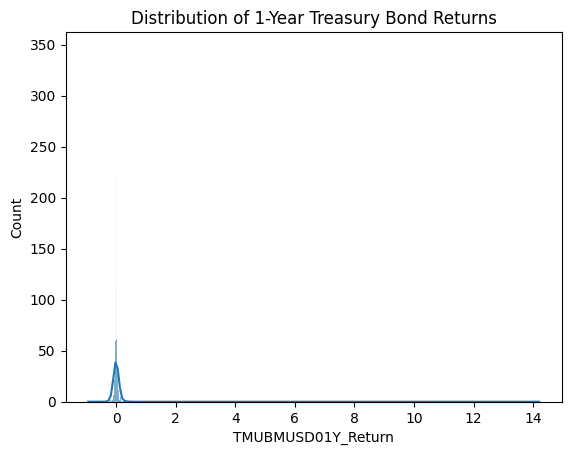

In [68]:
sns.histplot(df_combined_returns['TMUBMUSD01Y_Return'], kde=True)
plt.title('Distribution of 1-Year Treasury Bond Returns')
plt.show()

### Plots

The box plots reveal that both the S&P 500 and Bitcoin returns have numerous outliers, indicating extreme values, while the 1-Year U.S. Treasury Bond returns exhibit significant positive outliers. 

These findings suggest the need to investigate whether these extreme values are associated with specific market events.

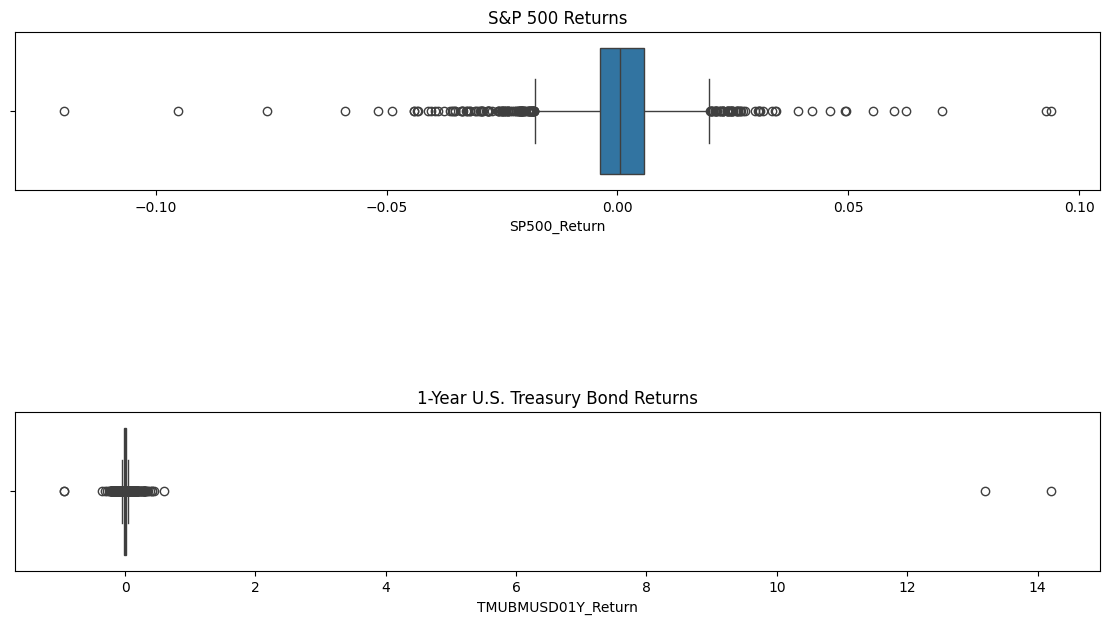

In [69]:
plt.figure(figsize=(14, 7))

plt.subplot(3, 1, 1)
sns.boxplot(x=df_combined_returns['SP500_Return'])
plt.title('S&P 500 Returns')



plt.subplot(3, 1, 3)
sns.boxplot(x=df_combined_returns['TMUBMUSD01Y_Return'])
plt.title('1-Year U.S. Treasury Bond Returns')

plt.show()

### Outliers

In [70]:
def extreme_values(df, column, percentile=0.01):
    threshold_high = df[column].quantile(1 - percentile)
    threshold_low = df[column].quantile(percentile)
    high = df[df[column] >= threshold_high]
    low = df[df[column] <= threshold_low]
    return high, low

In [71]:
high_sp500, low_sp500 = extreme_values(df_combined_returns, 'SP500_Return')
high_btc, low_btc = extreme_values(df_combined_returns, 'BTC_Return')
high_treasury, low_treasury = extreme_values(df_combined_returns, 'TMUBMUSD01Y_Return')

In [72]:
extreme_sp500_dates = high_sp500.index.union(low_sp500.index)
print(extreme_sp500_dates)

DatetimeIndex(['2015-08-24', '2015-08-26', '2016-06-24', '2018-02-05',
               '2018-02-08', '2018-03-26', '2018-10-10', '2018-12-26',
               '2019-01-04', '2020-02-24', '2020-02-27', '2020-03-02',
               '2020-03-04', '2020-03-05', '2020-03-09', '2020-03-10',
               '2020-03-11', '2020-03-12', '2020-03-13', '2020-03-16',
               '2020-03-17', '2020-03-18', '2020-03-20', '2020-03-24',
               '2020-03-26', '2020-03-27', '2020-03-30', '2020-04-01',
               '2020-04-06', '2020-04-08', '2020-04-14', '2020-04-17',
               '2020-04-29', '2020-05-18', '2020-06-11', '2020-09-03',
               '2020-10-28', '2022-04-29', '2022-05-04', '2022-05-05',
               '2022-05-18', '2022-06-13', '2022-06-24', '2022-07-19',
               '2022-08-26', '2022-09-13', '2022-10-04', '2022-10-17',
               '2022-11-10', '2022-11-30'],
              dtype='datetime64[ns]', name='Date', freq=None)


In [73]:
extreme_btc_dates = high_btc.index.union(low_btc.index)
print(extreme_btc_dates)

DatetimeIndex(['2014-11-12', '2015-01-13', '2015-01-14', '2015-01-15',
               '2015-11-02', '2015-11-10', '2016-01-15', '2016-06-22',
               '2016-08-02', '2017-01-05', '2017-01-11', '2017-07-17',
               '2017-07-20', '2017-09-14', '2017-09-15', '2017-09-18',
               '2017-10-12', '2017-12-06', '2017-12-07', '2017-12-22',
               '2017-12-26', '2018-01-05', '2018-01-16', '2018-02-05',
               '2018-04-12', '2018-11-19', '2019-04-02', '2019-05-13',
               '2019-06-27', '2019-07-16', '2019-09-24', '2019-10-25',
               '2020-03-12', '2020-03-13', '2020-03-19', '2020-03-23',
               '2020-04-29', '2021-01-21', '2021-02-08', '2021-05-12',
               '2021-05-19', '2021-05-24', '2021-06-09', '2021-06-21',
               '2021-09-07', '2022-02-04', '2022-02-28', '2022-05-09',
               '2022-06-13', '2022-11-09'],
              dtype='datetime64[ns]', name='Date', freq=None)


In [74]:
extreme_treasury_dates = high_treasury.index.union(low_treasury.index)
print(extreme_treasury_dates)

DatetimeIndex(['2014-06-24', '2014-07-22', '2014-08-19', '2014-09-16',
               '2014-10-14', '2014-10-15', '2014-11-12', '2014-12-10',
               '2015-02-03', '2015-02-06', '2015-03-03', '2015-03-18',
               '2015-06-23', '2015-09-15', '2015-09-17', '2015-10-02',
               '2016-06-24', '2020-02-28', '2020-03-03', '2020-03-04',
               '2020-03-05', '2020-03-06', '2020-03-10', '2020-03-16',
               '2020-03-18', '2020-03-20', '2020-03-24', '2020-03-25',
               '2020-03-26', '2020-03-30', '2020-03-31', '2020-05-07',
               '2021-02-18', '2021-02-22', '2021-02-23', '2021-03-19',
               '2021-03-29', '2021-05-20', '2021-06-16', '2021-07-15',
               '2021-07-16', '2021-07-22', '2021-07-23', '2021-11-03',
               '2021-11-05', '2021-11-26', '2021-12-01', '2021-12-29',
               '2022-01-26', '2022-02-10'],
              dtype='datetime64[ns]', name='Date', freq=None)


### Conclusion

COVID-19 pandemic was the major driver of extreme market movements across these different asset classes.

## Rolling Statistics

#### Calculate and plot rolling std for all portfolios with 21-day window

In [75]:
# Reference: Portfolio_Performance repository
# File: whale_analysis.ipynb
# URL: https://github.com/lrb924/Portfolio_Performance/blob/main/whale_analysis.ipynb

window = 21

df_assets['SP500_Rolling_Mean'] = df_assets['SP500_Return'].rolling(window).mean()
df_assets['SP500_Rolling_Std'] = df_assets['SP500_Return'].rolling(window).std()

df_assets['BTC_Rolling_Mean'] = df_assets['BTC_Return'].rolling(window).mean()
df_assets['BTC_Rolling_Std'] = df_assets['BTC_Return'].rolling(window).std()

df_assets['TMUBMUSD01Y_Rolling_Mean'] = df_assets['TMUBMUSD01Y_Return'].rolling(window).mean()
df_assets['TMUBMUSD01Y_Rolling_Std'] = df_assets['TMUBMUSD01Y_Return'].rolling(window).std()

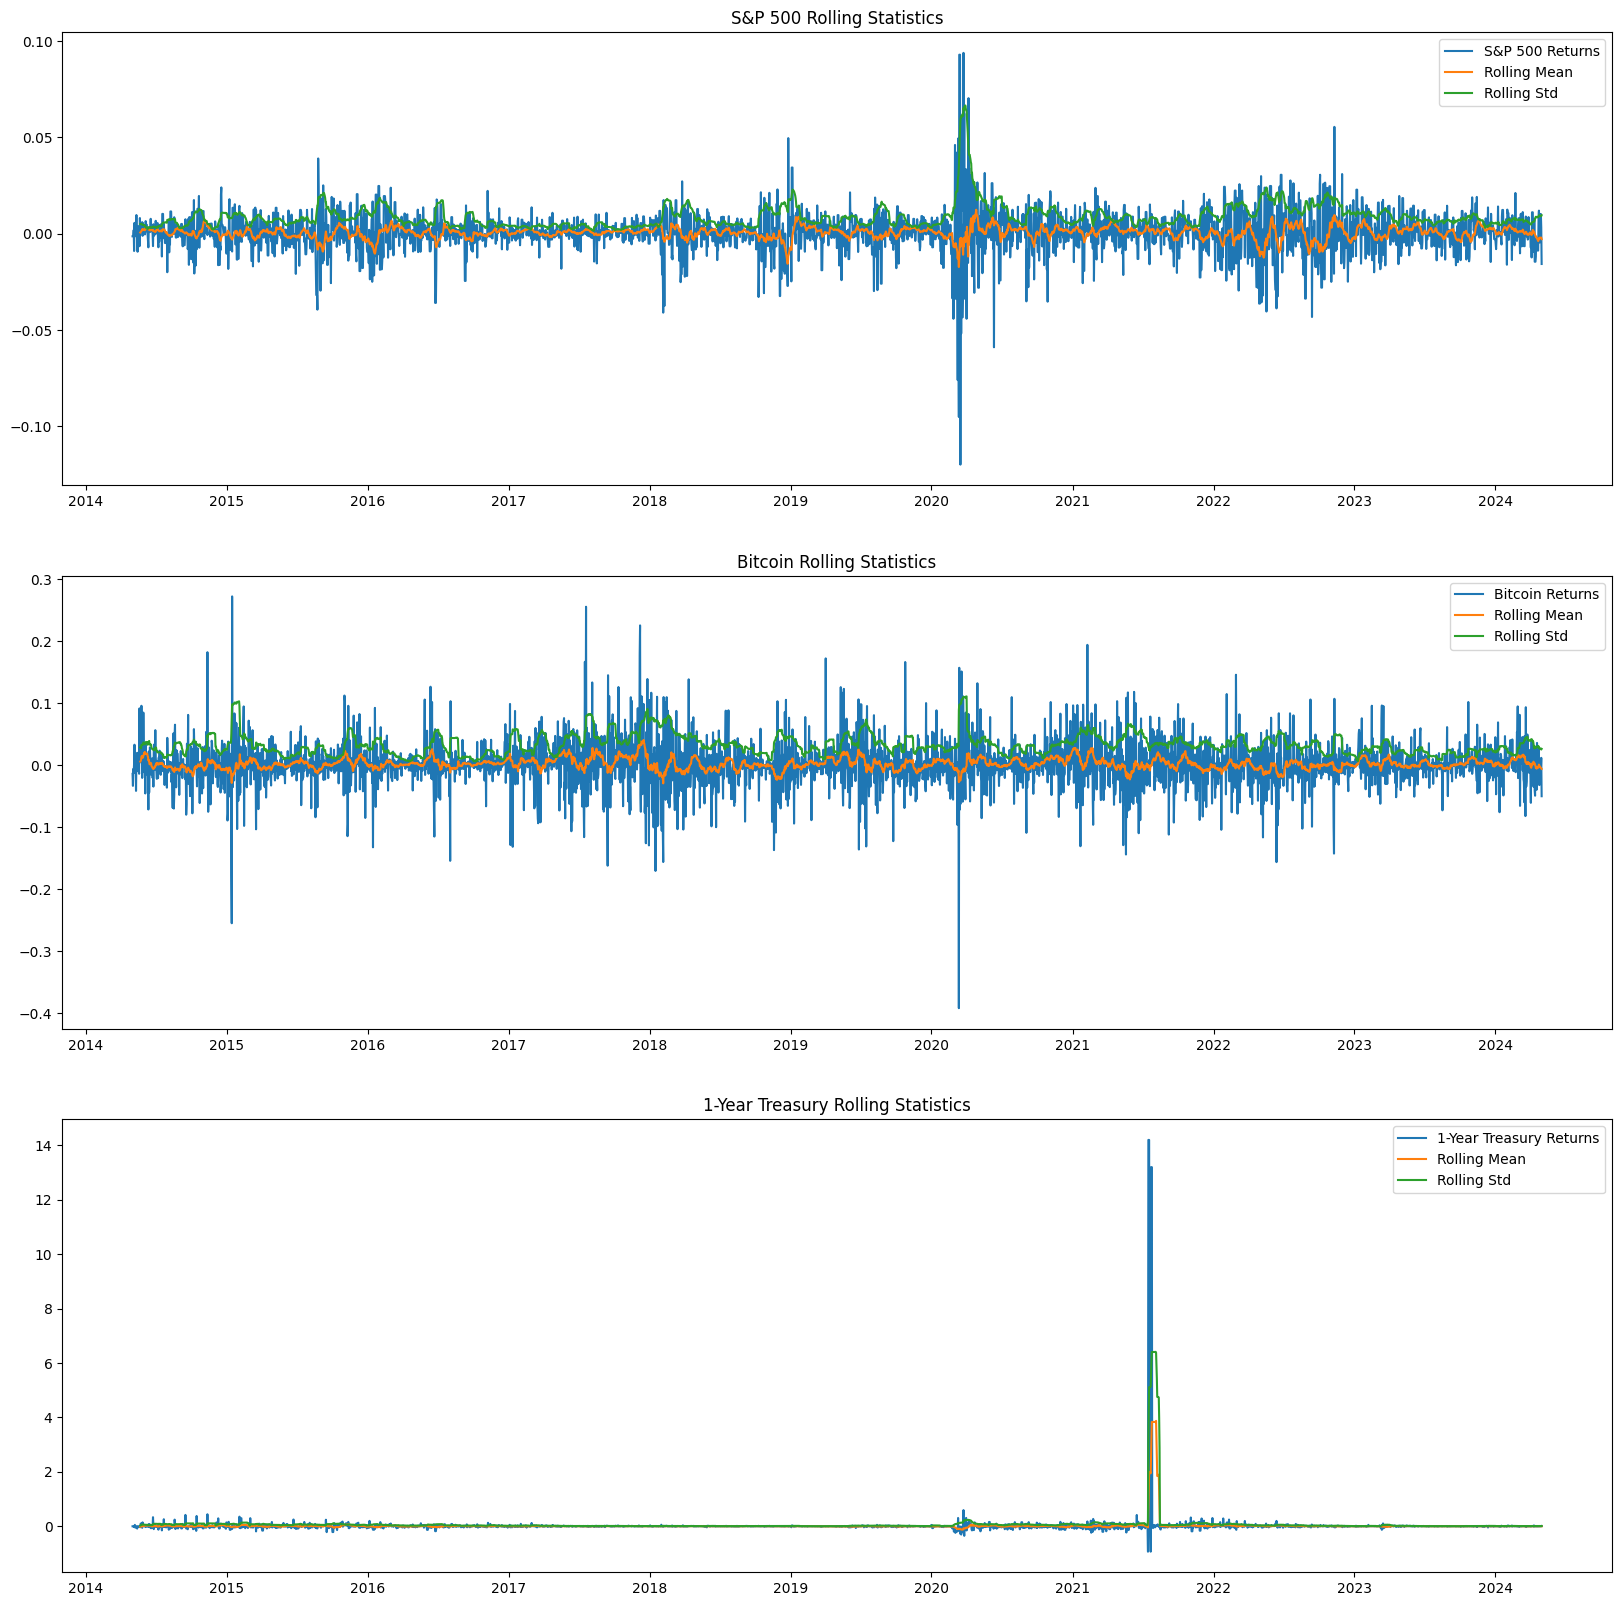

In [76]:
plt.figure(figsize=(20, 20))

plt.subplot(3, 1, 1)
plt.plot(df_assets.index, df_assets['SP500_Return'], label='S&P 500 Returns')
plt.plot(df_assets.index, df_assets['SP500_Rolling_Mean'], label='Rolling Mean')
plt.plot(df_assets.index, df_assets['SP500_Rolling_Std'], label='Rolling Std')
plt.title('S&P 500 Rolling Statistics')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(df_assets.index, df_assets['BTC_Return'], label='Bitcoin Returns')
plt.plot(df_assets.index, df_assets['BTC_Rolling_Mean'], label='Rolling Mean')
plt.plot(df_assets.index, df_assets['BTC_Rolling_Std'], label='Rolling Std')
plt.title('Bitcoin Rolling Statistics')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(df_assets.index, df_assets['TMUBMUSD01Y_Return'], label='1-Year Treasury Returns')
plt.plot(df_assets.index, df_assets['TMUBMUSD01Y_Rolling_Mean'], label='Rolling Mean')
plt.plot(df_assets.index, df_assets['TMUBMUSD01Y_Rolling_Std'], label='Rolling Std')
plt.title('1-Year Treasury Rolling Statistics')
plt.legend()

plt.show()

- S&P 500: The average returns are stable, but volatility spiked during the COVID-19 pandemic in early 2020, indicating increased market uncertainty.

- Bitcoin: Returns are more volatile than the S&P 500, with several large spikes, showing higher risk and instability, especially during economic events.

- 1-Year Treasury Bond: Typically very stable with low volatility, except for a sharp increase during the COVID-19 pandemic, reflecting its role as a safe-haven asset.

## ACF & PACF

<Figure size 1200x600 with 0 Axes>

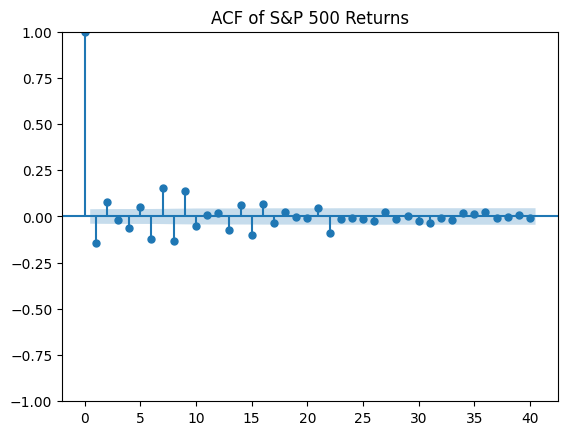

<Figure size 1200x600 with 0 Axes>

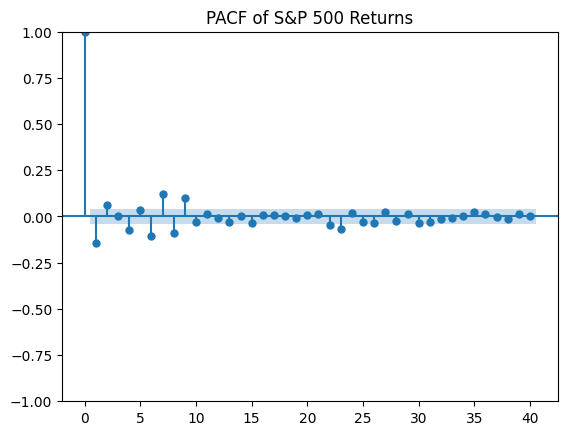

In [77]:
plt.figure(figsize=(12, 6))
plot_acf(df_combined_returns['SP500_Return'].dropna(), lags=40)
plt.title('ACF of S&P 500 Returns')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(df_combined_returns['SP500_Return'].dropna(), lags=40)
plt.title('PACF of S&P 500 Returns')
plt.show()

<Figure size 1200x600 with 0 Axes>

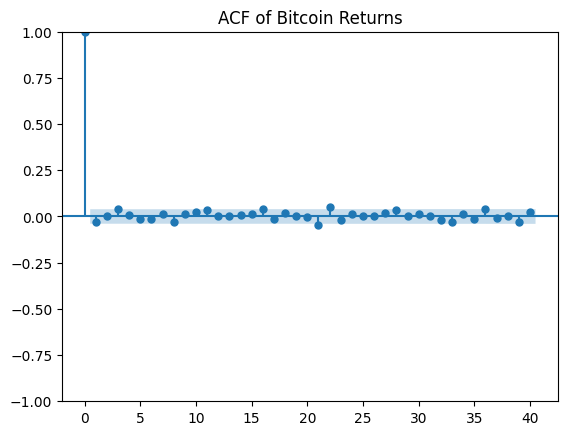

<Figure size 1200x600 with 0 Axes>

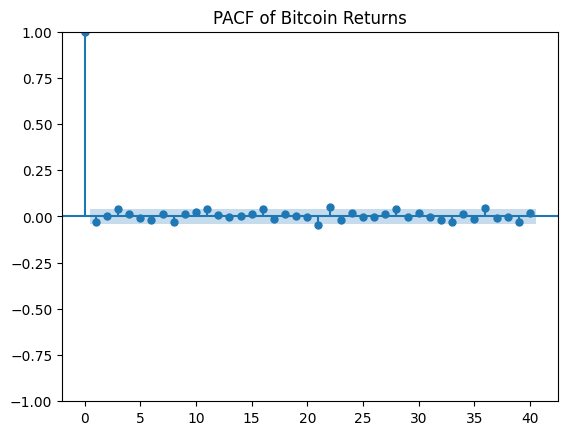

In [78]:
plt.figure(figsize=(12, 6))
plot_acf(df_combined_returns['BTC_Return'].dropna(), lags=40)
plt.title('ACF of Bitcoin Returns')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(df_combined_returns['BTC_Return'].dropna(), lags=40)
plt.title('PACF of Bitcoin Returns')
plt.show()

<Figure size 1200x600 with 0 Axes>

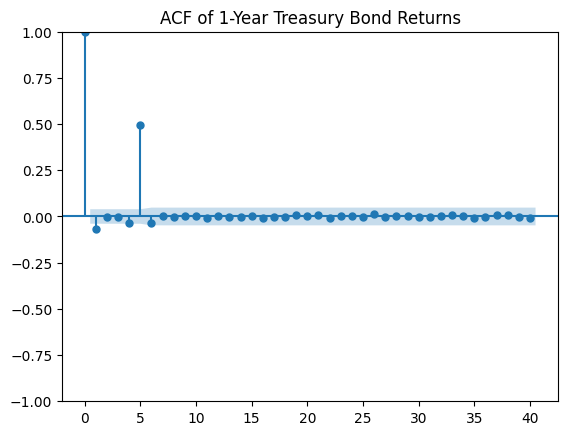

<Figure size 1200x600 with 0 Axes>

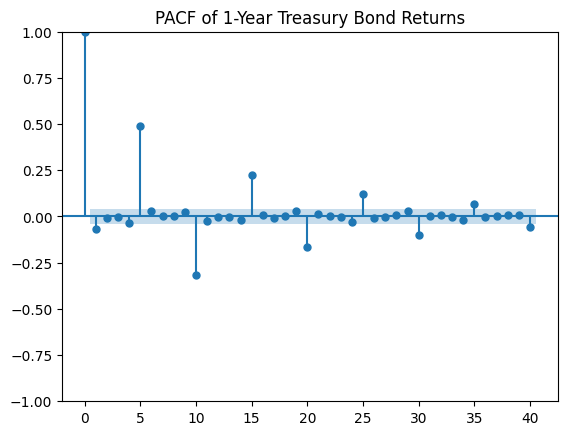

In [79]:
plt.figure(figsize=(12, 6))
plot_acf(df_combined_returns['TMUBMUSD01Y_Return'].dropna(), lags=40)
plt.title('ACF of 1-Year Treasury Bond Returns')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(df_combined_returns['TMUBMUSD01Y_Return'].dropna(), lags=40)
plt.title('PACF of 1-Year Treasury Bond Returns')
plt.show()

## Parametric method to calculate VaR

In [95]:

# We assign equal weights to our portfolio 
weights = np.array([0.33, 0.33, 0.33])
print(df_combined_returns)

cov_matrix = df_combined_returns.cov()
print(cov_matrix)
# Calculating portfolio mean and standard deviation
mean_returns = np.mean(df_combined_returns)
portfolio_mean = np.dot(weights, mean_returns)
portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
portfolio_std_dev = np.sqrt(portfolio_variance)


            SP500_Return  BTC_Return  TMUBMUSD01Y_Return
Date                                                    
2014-05-01           NaN         NaN                 NaN
2014-05-02     -0.001348   -0.013910            0.000000
2014-05-05      0.001871   -0.011697           -0.019231
2014-05-06     -0.008988    0.003017            0.000000
2014-05-07      0.005616    0.033087           -0.029412
...                  ...         ...                 ...
2024-04-24      0.000213   -0.032061            0.001944
2024-04-25     -0.004576    0.003288            0.010475
2024-04-26      0.010209   -0.011329           -0.002496
2024-04-29      0.003178    0.011890           -0.000192
2024-04-30     -0.015731   -0.050008            0.009432

[2501 rows x 3 columns]
                    SP500_Return  BTC_Return  TMUBMUSD01Y_Return
SP500_Return            0.000125    0.000092            0.000100
BTC_Return              0.000092    0.001591            0.000128
TMUBMUSD01Y_Return      0.000100    0.0

In [90]:
#Calculating VaR with 95% confidence level:
confidence_level = 0.95
z_score = 1.65  # z-score for 95% confidence level
VaR = z_score * portfolio_std_dev

print(f"Portfolio Value at Risk (VaR) at 95% confidence level is: {VaR}")


Portfolio Value at Risk (VaR) at 95% confidence level is: 0.13305531728497638


This means that, with 95% confidence, our portfolio's maximum loss is not expected to exceed 13.31% in one day. 
On the other hand, there is 5% chance that our portfolio will lose more than 13.31% of initial investment. 